In [20]:
%load_ext autoreload
%autoreload 2
import mantis_core.rock_physics as manRP
import mantis_core.rock_physics.fluid as manFL
import mantis_core.interface as manIT
import mantis_core._literature as manLIT
from mantis_core.rock_physics.fluid_presets import presets as manPResets
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


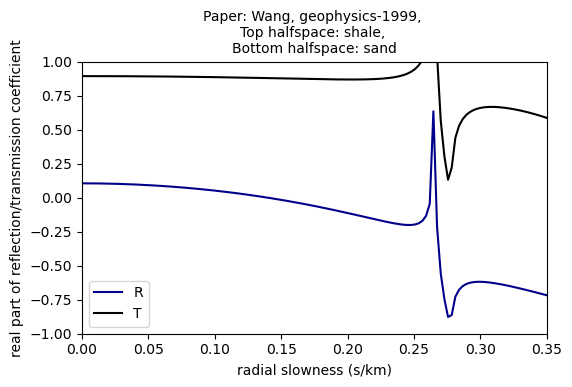

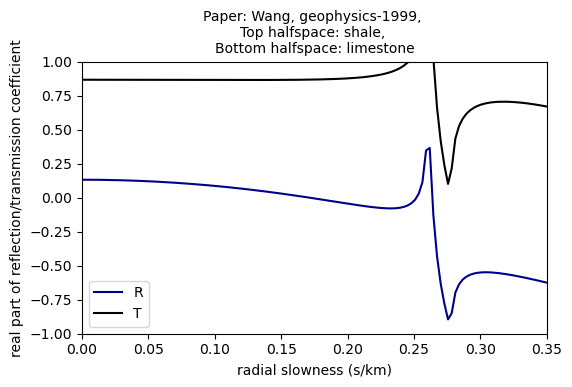

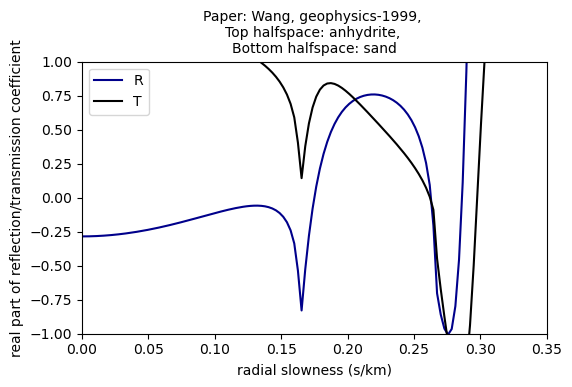

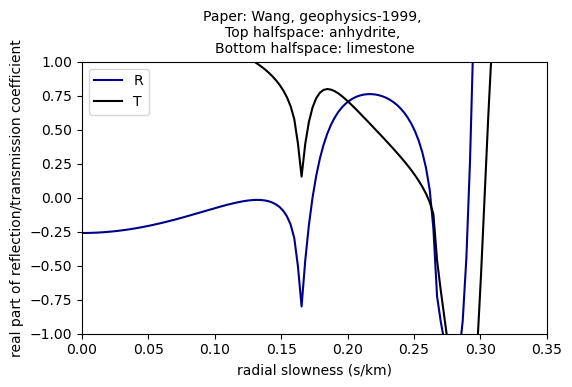

In [30]:
from avo_backend.run_examples import run_example, plotting
resolution: int = 128
s0 = np.linspace(0.0001, 0.35, resolution)
paper = "Wang, geophysics-1999"
pairs = (
    ("shale", "sand"),
    ("shale", "limestone"),
    ("anhydrite", "sand"),
    ("anhydrite", "limestone"),
)
azimuth = 0.0
for top, bot in pairs:
    ref, descr = run_example(paper, medium1=top, medium2=bot)
    data = np.asarray(
            [
                ref(radial_slowness * np.array([np.cos(azimuth), np.sin(azimuth)]))
                for radial_slowness in s0
            ]
        )
    plotting(data[:, :, 0, 0].T, labels=["R", "T"], title=descr)

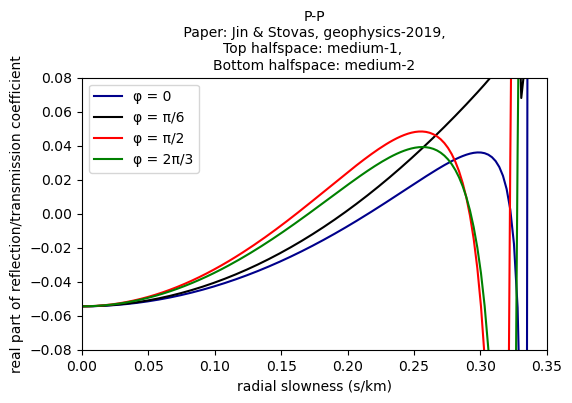

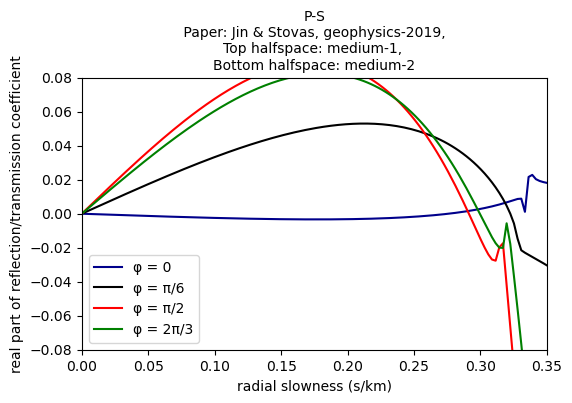

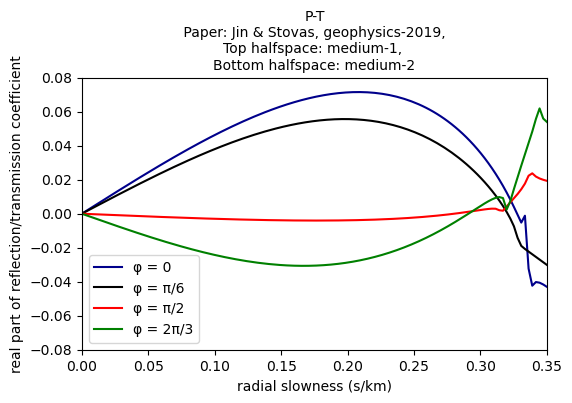

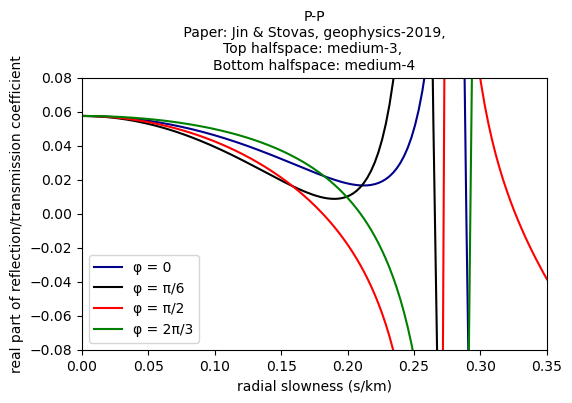

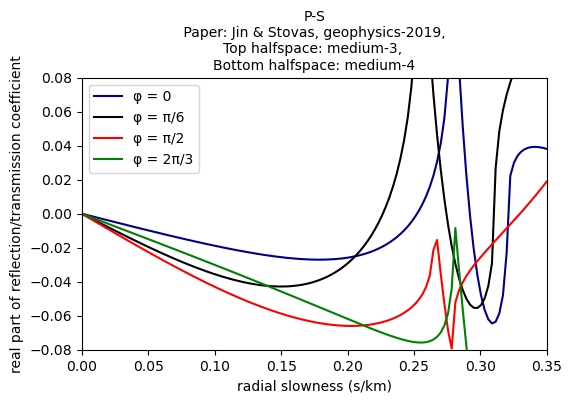

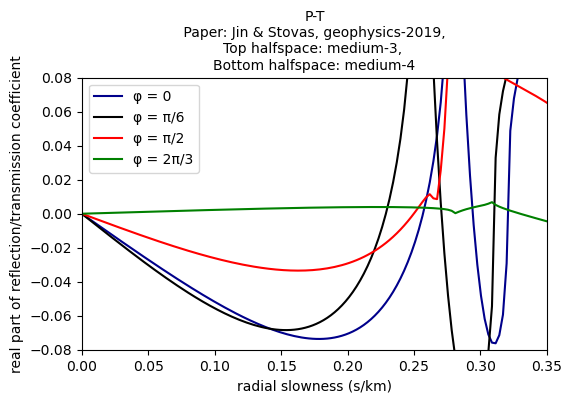

In [31]:
paper = "Jin & Stovas, geophysics-2019"
pairs = (("medium-1", "medium-2"), ("medium-3", "medium-4"))

azimuthal_angles = (0.0, np.pi / 6.0, np.pi / 2.0, 2.0 * np.pi / 3.0)
labels = ["φ = 0", "φ = π/6", "φ = π/2", "φ = 2π/3"]
labels2 = ["P-P", "P-S", "P-T"]
for top, bot in pairs:
    ref, descr = run_example(
        paper, medium1=top, medium2=bot, relative_azimuth=np.pi / 4
    )
    data = np.asarray(
        [
            [ref(s * np.array([np.cos(phi), np.sin(phi)]))[0][:, 0] for s in s0]
            for phi in azimuthal_angles
        ]
    )
    [
        plotting(
            d.T,
            labels=labels,
            title=f"{labels2[i]}\n {descr}",
            y_range=(-0.08, 0.08),
        )
        for i, d in enumerate(data.T)
    ]

In [54]:
import mantis_core.utilities as manU
top_properties = {"Vp": 3.0, "Vs": 1.5, "Rho": 2.4}
bot_properties = {"Vp": 3.5, "Vs": 1.7, "Rho": 2.6}

layer1 = manIT.SchoenbergProtazio(
    Cij=manU.VtoCij(**top_properties),
    density=top_properties["Rho"],
)
layer2 = manIT.SchoenbergProtazio(
    Cij=manU.VtoCij(**bot_properties),
    density=bot_properties["Rho"],
)
rt =  manIT.ReflectionTransmissionMatrix.sp_init(spUp=layer1, spDown=layer2)
reflection, transmission = rt(horizontal_slowness=[0.2,0.0])

In [55]:
with np.printoptions(precision=5, suppress=True):
    print(f"reflection matrix:\n{reflection} \ntransmission matrix:\n{transmission}")

reflection matrix:
[[ 0.1093 -0.j -0.0474 -0.j  0.     +0.j]
 [-0.07951-0.j -0.04582-0.j  0.     +0.j]
 [ 0.     +0.j  0.     +0.j -0.09518-0.j]] 
transmission matrix:
[[ 0.93249-0.j  0.04443-0.j  0.     +0.j]
 [-0.067  -0.j  0.90457-0.j  0.     +0.j]
 [ 0.     +0.j  0.     +0.j  0.9382 -0.j]]
